In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [84]:
df = pd.read_csv("/workspaces/Customer_Churn_Prediction_Group_06/Customer_Churn_Prediction_Group_06/dataset/churn_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [85]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [86]:
# Drop rows with missing TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

In [87]:
# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

In [88]:
# Separate categorical & numerical
cat_cols = df.select_dtypes(include=["object"]).columns
num_cols = df.select_dtypes(exclude=["object"]).columns

In [89]:
# Label Encoding for binary categories
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [90]:
# 5. Define features (X) and target (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]  # 1 = churn, 0 = no churn

In [91]:
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [92]:
# 7. Define base learner
base_clf = DecisionTreeClassifier(max_depth=1, random_state=42)

In [93]:
# --- AdaBoost (version safe) ---
if sklearn.__version__ >= "1.2":
    adaboost = AdaBoostClassifier(
        estimator=base_clf,
        n_estimators=100,
        learning_rate=0.5,
        random_state=42
    )
else:
    adaboost = AdaBoostClassifier(
        base_estimator=base_clf,
        n_estimators=100,
        learning_rate=0.5,
        random_state=42
    )

In [94]:
# 8. Train the model
adaboost.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.5, n_estimators=100, random_state=42)

In [95]:
# 9. Predictions
y_pred = adaboost.predict(X_test)
y_prob = adaboost.predict_proba(X_test)[:, 1]

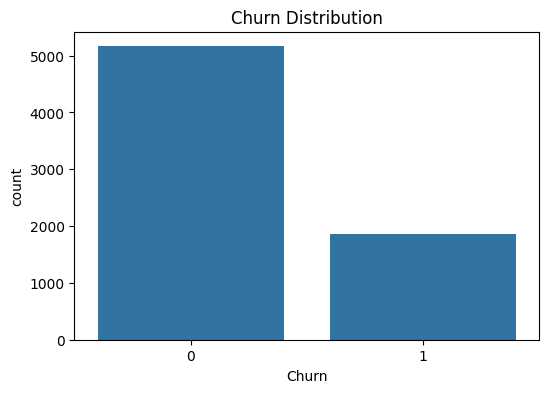

In [96]:
# Plots
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

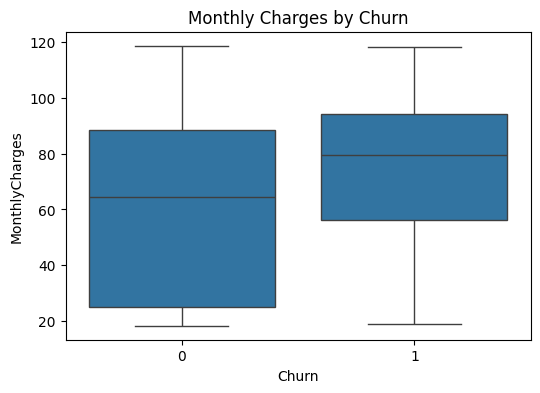

In [97]:
# Plots
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()

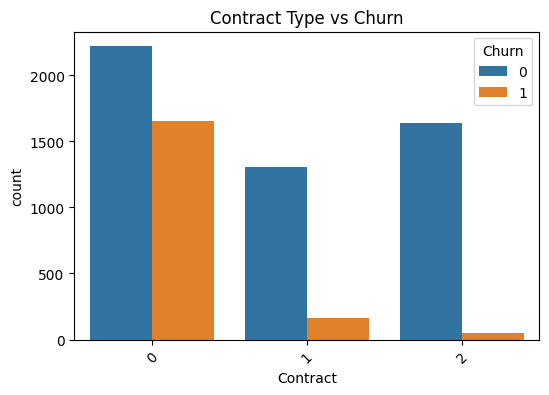

In [98]:
# Plots
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=45)
plt.show()


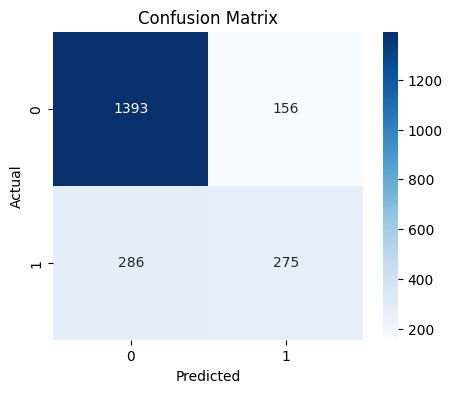

In [99]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [100]:
# --- Evaluation ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, adaboost.predict_proba(X_test)[:,1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.790521327014218
ROC AUC: 0.8298994578757614

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.49      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.71      2110
weighted avg       0.78      0.79      0.78      2110

